In [1]:
import datetime as dt
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import pandas as pd
import pandas_datareader.data as web
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Dataset Creation and Random Forest Regressor

In [2]:
ticker = 'spy' 
end = dt.datetime.now() 
start = end - dt.timedelta(days = 365*15)

def taStock(ticker,start,end):
    df = web.DataReader(ticker.upper(),'yahoo',start,end)
    data = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)
    data['forecast'] = data['Adj Close'].shift(-1)
    data['Daily Return'] = (data['forecast'].pct_change())*100
    data['target'] = int(False)
    data.loc[data['Daily Return'] > 0, 'target']=int(True)
    data = data.dropna() 
    symbols_list = 'DGS10','FEDFUNDS','LIBOR','USD3MTD156N','UNRATE','PAYEMS','IC4WSA','VIXCLS','BAMLCC0A0CMTRIV','BAMLHYH0A0HYM2TRIV'
    symbols = []
    for symbol in symbols_list: 
        try:
            r = web.DataReader(symbol,'fred',start,end)
            r[f'{symbol}'] = r[f'{symbol}']
            r1 = r[[f'{symbol}']]
            symbols.append(r1)
        except:
            msg = 'Failed to read symbol: {0!r}, replacing with NaN.'

    df = pd.concat(symbols, sort=False, axis=1)
    df = df.fillna(method='ffill')
    data = pd.concat([data,df],axis=1)
    data = data.dropna()
    return data
data = taStock(ticker,start,end)
data = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'momentum_mfi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_kama', 'momentum_roc', 'others_dr',
       'others_dlr', 'others_cr', 'forecast', 'Daily Return', 'target',
       'DGS10', 'FEDFUNDS', 'USD3MTD156N', 'UNRATE', 'PAYEMS', 'IC4WSA',
       'VIXCLS', 'BAMLCC0A0CMTRIV', 'BAMLHYH0A0HYM2TRIV']]

X = data.loc[:,data.columns!='forecast']
Y = data['forecast']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=50,test_size=0.2)
rfr = RandomForestRegressor(random_state=50,oob_score=True,max_features='sqrt')
rfr.fit(X_train,Y_train)
y_rfr_pred = rfr.predict(X_test)
print('Train r squared score:',r2_score(Y_train,rfr.predict(X_train)))
print('Test r squared score:',r2_score(Y_test,rfr.predict(X_test)))

Train r squared score: 0.9998549685026621
Test r squared score: 0.9987515378518409


# Optimization of the features to be used in the Neural Network

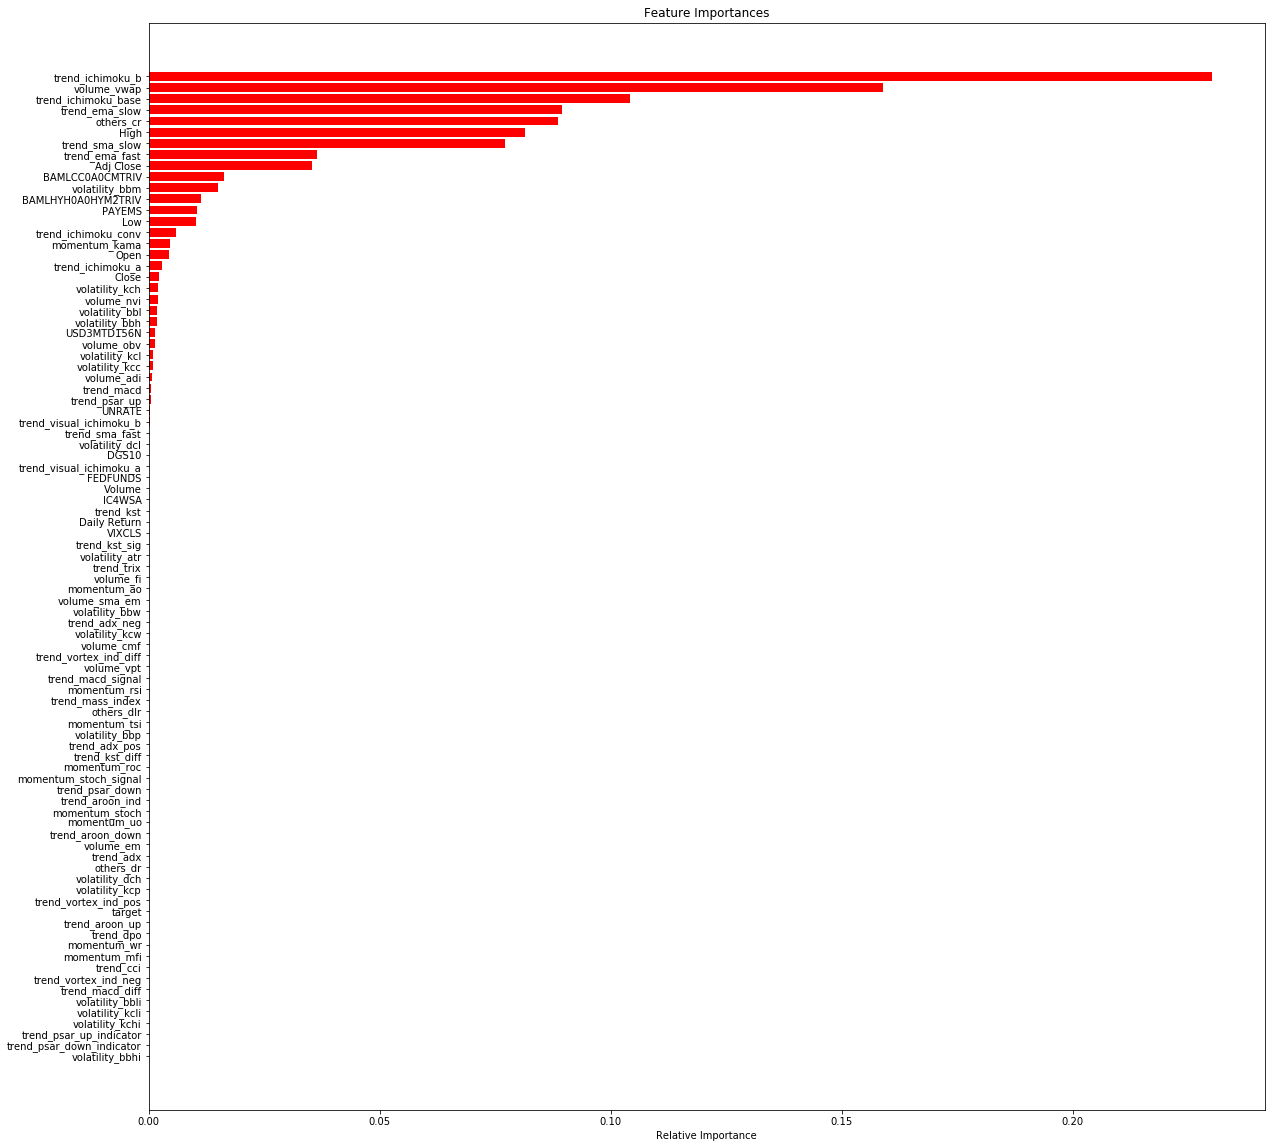

In [3]:
features = X_train.columns
importances = rfr.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(20,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices],color='r',align='center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Features for the ANN

In [10]:
new_features = features[indices][-10:]
print(new_features)
X = data[new_features]
Y = data[['forecast']]
random.seed(100)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=50,test_size=0.2)
X_val,X_test,Y_val,Y_test = train_test_split(X_test,Y_test,random_state=50,test_size=0.5)

Index(['BAMLCC0A0CMTRIV', 'Adj Close', 'trend_ema_fast', 'trend_sma_slow',
       'High', 'others_cr', 'trend_ema_slow', 'trend_ichimoku_base',
       'volume_vwap', 'trend_ichimoku_b'],
      dtype='object')


In [11]:
#number of steps function given the batch size
def num_steps(length: int,batch_size = int):
    return length//batch_size+1
batch_size = 32
num_steps(len(X_train), batch_size)

95

In [12]:
#ann model for stock prediction
def stock_predictor_model(x_train):
    model = Sequential()
    # One Dense layer with number of units same as features
    model.add(Dense(100, input_dim=x_train.shape[1],
                    activation=tf.nn.leaky_relu,
                    kernel_initializer='he_normal'))
    model.add(Dense(60, input_dim=100,
                    activation=tf.nn.leaky_relu,
                    kernel_initializer='he_normal'))
    model.add(Dense(30, input_dim=60,
                activation=tf.nn.leaky_relu,
                kernel_initializer='he_normal'))
    # Final dense layer
    model.add(Dense(1, activation=tf.nn.leaky_relu,
                    kernel_initializer='he_normal'))
    # Using mse as loss and mape as the metric
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mape'])
    return model

model = stock_predictor_model(X_train)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_6 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 9,021
Trainable params: 9,021
Non-trainable params: 0
_________________________________________________________________


In [13]:
#training the model
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
history = model.fit(X_train, Y_train, 
                    validation_data=[X_val, Y_val],
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1)

Train on 3012 samples, validate on 377 samples
Epoch 1/10
3012/3012 [==============================] - 1s 166us/step - loss: 10645.1410 - mape: 42.9831 - val_loss: 137.1028 - val_mape: 8.0682
Epoch 2/10
3012/3012 [==============================] - 0s 77us/step - loss: 72.0093 - mape: 5.1077 - val_loss: 57.5002 - val_mape: 4.6263
Epoch 3/10
3012/3012 [==============================] - 0s 90us/step - loss: 29.5361 - mape: 3.2798 - val_loss: 26.5346 - val_mape: 3.0714
Epoch 4/10
3012/3012 [==============================] - 0s 79us/step - loss: 16.0697 - mape: 2.2731 - val_loss: 16.9786 - val_mape: 2.1050
Epoch 5/10
3012/3012 [==============================] - 0s 83us/step - loss: 15.2755 - mape: 2.1996 - val_loss: 58.9677 - val_mape: 4.6896
Epoch 6/10
3012/3012 [==============================] - 0s 82us/step - loss: 17.0208 - mape: 2.2957 - val_loss: 50.8646 - val_mape: 4.3636
Epoch 7/10
3012/3012 [==============================] - 0s 79us/step - loss: 14.3432 - mape: 2.1437 - val_loss: 1

In [15]:
pred_data = taStock(ticker,start,end)[new_features]
pred_features = pred_data.iloc[-1]
pred_features = np.array([[pred_features[0],pred_features[1],pred_features[2],pred_features[3],pred_features[4],pred_features[5],pred_features[6],pred_features[7],pred_features[8],pred_features[9]]])
prediction = model.predict(pred_features)
print(f'The predicted stock price for {ticker} for tomorrow is ${float(prediction[0])}.')

The predicted stock price for spy for tomorrow is $315.6796569824219.
